/Users/pavan/Library/Python/3.9/lib/python/site-packages/torch/_tensor.py:761: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


4.551247596740723
iter:0 training loss: 4.54750919342041, val loss: 4.551247596740723
iter:5 training loss: 3.174034357070923, val loss: 3.2106735706329346
iter:10 training loss: 2.887373447418213, val loss: 2.9324519634246826
iter:15 training loss: 2.708733320236206, val loss: 2.7538034915924072
iter:20 training loss: 2.5988576412200928, val loss: 2.6416876316070557
iter:25 training loss: 2.5207417011260986, val loss: 2.563701629638672
iter:30 training loss: 2.4653546810150146, val loss: 2.510110378265381
iter:35 training loss: 2.4244601726531982, val loss: 2.4695982933044434
iter:40 training loss: 2.3900949954986572, val loss: 2.4362633228302
iter:45 training loss: 2.361879825592041, val loss: 2.4088082313537598
iter:50 training loss: 2.337476968765259, val loss: 2.3857297897338867
iter:55 training loss: 2.3153603076934814, val loss: 2.3645548820495605
iter:60 training loss: 2.29495906829834, val loss: 2.3459410667419434
iter:65 training loss: 2.2756283283233643, val loss: 2.32869935

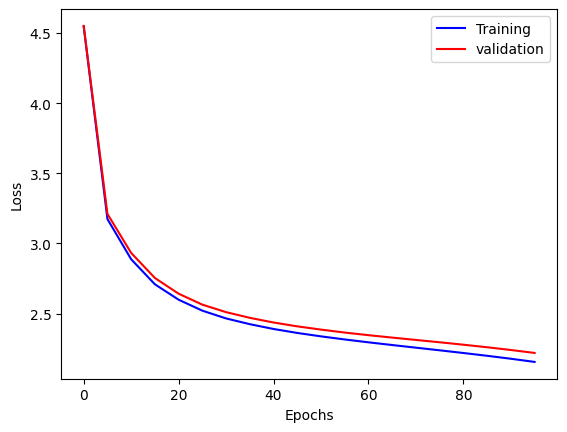

In [22]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
import time
import random
import math

inf = torch.inf
context_length = 8 # No of tokens
model_dim = 64 # dimension of the model -> residual stream
n_layers = 2 # no of layers
n_heads = 2 # No of attention heads for layer
head_dim = 8
vocab_size = 65
learning_rate = 0.01
max_iters = 100

lower_triangular_matrix = torch.tensor([[1 if i<=j else -torch.inf for i in range(context_length-1)] for j in range(context_length-1)]).float()



def sample_training_data():
    X = training_data[:,:-1]
    Y = training_data[:,1:] 
    return X,Y

torch.no_grad()
def get_val_loss():
    X = validation_data[:,:-1]
    Y = validation_data[:,1:]
    _, loss = model(X, Y)  # (B, context_length, vocab_size)

    return loss.item()


class AttentionHead(nn.Module):
    def __init__(self):
        super().__init__()
        self.key = nn.Linear(model_dim, head_dim)
        self.query = nn.Linear(model_dim, head_dim)
        self.value = nn.Linear(model_dim, head_dim)
        self.proj = nn.Linear(head_dim, model_dim)
    
    def forward(self, idx):
        key = self.key(idx) # (batch, context_length, head_dim)
        query = self.query(idx)
        value = self.value(idx) # (batch, context_length, head_dim)

        attention = (query@torch.transpose(key,1,2))/(math.sqrt(head_dim)) # (batch, context_length, context_length)

        attention = torch.tril(attention)

        attention = attention.masked_fill(attention == 0, -inf)

        attention = F.softmax(attention,1) # probs along context_length sum to 1

        attention_value = attention@value  # (batch, context_length, head_dim)

        return self.proj(attention_value)  # (batch, context_length, model_dim)
    

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(nn.Linear(model_dim, 4*model_dim), nn.Linear(4*model_dim, model_dim))
        self.relu = nn.ReLU()
    
    def forward(self, idx):
        logits = self.layers(idx)
        return self.relu(logits)

class Transformer(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_embedding = nn.Embedding(vocab_size, model_dim)
        self.pos_embedding = nn.Embedding(context_length-1, model_dim)
        self.attention_layes = [AttentionHead() for i in range(n_layers)]
        self.mlp_layers = [MLP() for i in range(n_layers)]
        self.unembed_layer = nn.Linear(model_dim,vocab_size)

    def forward(self, idx, targets = None):
        # idx -> [1,2,0,3..] (batch, context_length)

        residual_stream = self.token_embedding(idx)  # (batch, context_length, model_dim)
        residual_stream = residual_stream + self.pos_embedding(torch.tensor([i for i in range(context_length-1)])) # Pos embedding will be # (context_length, model_dim)
        
        for i in range(n_layers):
            residual_stream = residual_stream + self.attention_layes[i](residual_stream)
            residual_stream = residual_stream + self.attention_layes[i](residual_stream)

        residual_stream = self.unembed_layer(residual_stream) # (batch, context_length, vocab_size)
        if targets is None:
            return residual_stream
        (x,y,z) = residual_stream.shape
        loss = F.cross_entropy(residual_stream.resize(x*y,z), F.one_hot(targets, vocab_size).resize(x*y, z).float())
        return residual_stream, loss

def tokenise(str: str):
    return torch.tensor([char_map[i] for i in str])


file = open("tiny_shakesphere.txt", "r")
full_data = file.read()

vocab = list(sorted((set(full_data))))

char_map = {vocab[i]: i for i in range(len(vocab))}
full_data = tokenise(full_data)

full_data = full_data[:len(full_data)- len(full_data)%context_length].reshape(-1,context_length) # Make it multiple of context length

random.shuffle(full_data)
total_datapoints  = full_data.shape[0]//10
training_data = full_data[:int(total_datapoints*0.6), :]
validation_data = full_data[int(total_datapoints*0.6):total_datapoints,:]


model = Transformer()
print(get_val_loss())
loss_value = []
val_loss_value = []
iters = []
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
step_value = max_iters/20
start_time = time.time()
for iter in range(max_iters):
    X,Y= sample_training_data() # (B, context_length)
    logits, loss = model(X, Y)  # (B, context_length, vocab_size)
    if iter%step_value ==0:
        model.eval()
        with torch.no_grad():
            val_loss = get_val_loss()
            iters.append(iter)
            loss_value.append(loss.item())
            val_loss_value.append(val_loss)
            print(f"iter:{iter} training loss: {loss.item()}, val loss: {val_loss}")
        model.train()

    
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
end_time = time.time()
print(f"Took {end_time-start_time}s for {max_iters} epochs")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(iters,loss_value, color='blue', label="Training")
plt.plot(iters, val_loss_value, "red", label = "validation")
plt.legend()
plt.show()



        

In [ ]:
torch.softmax(attn,1)

tensor([[1.0000, 0.0000, 0.0000],
        [0.5077, 0.4923, 0.0000],
        [0.4229, 0.3701, 0.2071]])

In [12]:
datapoints

139424

In [47]:
full_data.shape[1]

8

In [16]:
data[:500]

"First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you know Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us kill him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be done: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor"

In [17]:
type(data)

str

In [23]:
list(sorted((set(data))))

['\n',
 ' ',
 '!',
 '$',
 '&',
 "'",
 ',',
 '-',
 '.',
 '3',
 ':',
 ';',
 '?',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']